##Mounting drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Importing Libraries:

In [2]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


##Loading and preprocessing the images:  
-loaded data and labels as images and their labels  
-converted images into 32x32  
-converted images into grayscale  
-shuffled randomly then taken 100 images for each class  
finally appended 300 images in data[] and their labels in labels[]

In [ ]:
base_path = '/content/drive/MyDrive/CVPR/dataset-assignment1/animals/animals'

data = []
labels = []
image_size = (32, 32)
categories = os.listdir(base_path)
random.seed(42)
for label, category in enumerate(categories):
    path = os.path.join(base_path, category)
    img_files = os.listdir(path)
    random.shuffle(img_files)
    selected_imgs = img_files[:100]
    for img_name in selected_imgs:
        img_path = os.path.join(path, img_name)
        img = Image.open(img_path).convert('L').resize(image_size)
        data.append(np.array(img).flatten())
        labels.append(label)

data = np.array(data)
labels = np.array(labels)

##Showcasing Some images and labels:

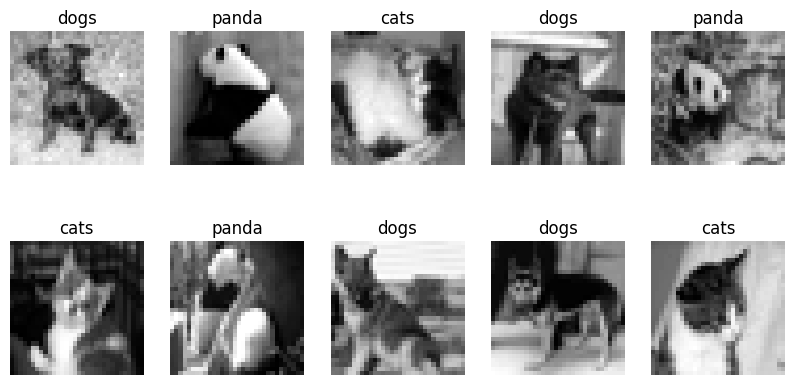

(300,)

In [4]:
plt.figure(figsize=(10,5))
for i in range(10):
    index = random.randint(0, len(data)-1)
    img = data[index].reshape(32, 32)
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(categories[labels[index]])
    plt.axis('off')
plt.show()
data.shape
labels.shape

##Shuffling and Splitting Data into 5 Folds:

In [5]:
indices = np.arange(len(data))
np.random.seed(42)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
fold_size = len(data) // 5
folds_data = [data[i*fold_size:(i+1)*fold_size] for i in range(5)]
folds_labels = [labels[i*fold_size:(i+1)*fold_size] for i in range(5)]

##Distance Functions:  
[Euclidean and Manhattan Distance](https://miro.medium.com/v2/resize:fit:1400/1*7M5rDo4WoYRWxkL6SiwQfQ.png)

In [6]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

##KNN Implementation:  
 The K-Nearest Neighbors (KNN) algorithm is applied to classify image data using two different distance metrics—Manhattan (L1) and Euclidean (L2). The model evaluates how well each metric performs across various K values to identify patterns and measure classification accuracy.

In [7]:
def knn(train_data, train_labels, test_sample, k, distance_type):
    distances = []
    for i in range(len(train_data)):
        if distance_type == 'L2':
            dist = euclidean_distance(train_data[i], test_sample)
        else:
            dist = manhattan_distance(train_data[i], test_sample)
        distances.append((dist, train_labels[i]))
    distances.sort(key=lambda x: x[0])
    neighbors = [label for _, label in distances[:k]]
    return max(set(neighbors), key=neighbors.count)

##Cross Validation and Accuracy Calculation:


In [8]:
k_values = [1, 3, 5, 7, 9]
l1_accuracies = []
l2_accuracies = []

for k in k_values:
    acc_l1 = []
    acc_l2 = []
    for i in range(5):
        val_data = folds_data[i]
        val_labels = folds_labels[i]
        train_data = np.concatenate([folds_data[j] for j in range(5) if j != i])
        train_labels = np.concatenate([folds_labels[j] for j in range(5) if j != i])

        correct_l1 = 0
        correct_l2 = 0
        for j in range(len(val_data)):
            pred_l1 = knn(train_data, train_labels, val_data[j], k, 'L1')
            pred_l2 = knn(train_data, train_labels, val_data[j], k, 'L2')
            if pred_l1 == val_labels[j]:
                correct_l1 += 1
            if pred_l2 == val_labels[j]:
                correct_l2 += 1
        acc_l1.append(correct_l1 / len(val_data))
        acc_l2.append(correct_l2 / len(val_data))
    l1_accuracies.append(np.mean(acc_l1))
    l2_accuracies.append(np.mean(acc_l2))

##Plotting Accuracy:


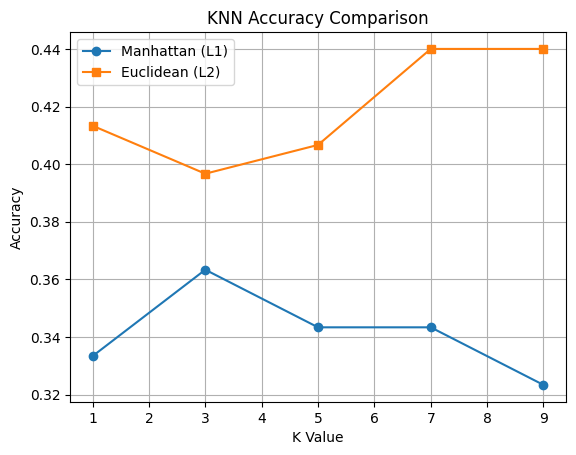

In [9]:
plt.plot(k_values, l1_accuracies, label='Manhattan (L1)', marker='o')
plt.plot(k_values, l2_accuracies, label='Euclidean (L2)', marker='s')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

##Analysis from the Result:  
-The plot reveals that Euclidean (L2) consistently outperforms Manhattan (L1) for this dataset.

-The L2 line shows a steady increase in accuracy up to K=7 and maintains a higher accuracy (\~0.44) compared to L1, which fluctuates and peaks lower (~0.36).

-This suggests that for this image classification task, Euclidean distance is a better fit.

##Top 5 Predictions from Model:


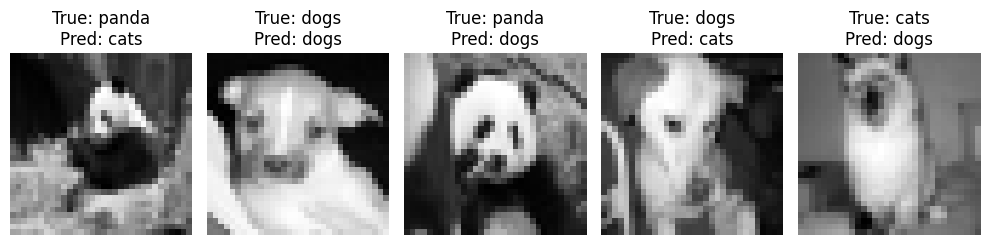

In [10]:
test_indices = random.sample(range(len(data)), 5)
train_data_full = np.delete(data, test_indices, axis=0)
train_labels_full = np.delete(labels, test_indices, axis=0)

plt.figure(figsize=(10,5))
for i, idx in enumerate(test_indices):
    sample = data[idx]
    label = labels[idx]
    pred = knn(train_data_full, train_labels_full, sample, k=3, distance_type='L2')
    plt.subplot(1, 5, i+1)
    plt.imshow(sample.reshape(32, 32), cmap='gray')
    plt.title(f'True: {categories[label]}\nPred: {categories[pred]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

##Discussion:  
This part displays 5 randomly chosen test images along with their true labels and model predictions.  
-The model misclassifies 4 out of 5 images, struggling particularly with distinguishing between cats, dogs, and pandas.  
-For instance, the first image is a panda but predicted as a cat, and the third one, also a panda, is labeled as dog.  
-This highlights the limitations of the current KNN configuration and suggests room for improvement in feature representation or model tuning.